In [1]:
from IPython.display import clear_output
!pip install requests
!pip install --upgrade pandas
!pip install konlpy
!pip install gensim
!cp -R /home/work/deep/jdk1.8.0_201 /usr/lib/jvm
clear_output()

In [2]:
!pip install plotly
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('kyoh', 'xLxYyOTECJ48ofwzrn2j')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
clear_output()

In [3]:
import pandas as pd
import numpy as np
import requests
features = []

### 1) 국제 원유가격 데이터에서 예측할 두바이유 데이터 로드 및 추세 확인
### 2) 피쳐로 사용할 데이터 탐색 
### - 국제 유가 관련 뉴스 데이터(제외)
### - 다우 존스 데이터
### - 환율 데이터
### - 코스피 데이터
### - Brent 데이터
### - WTI 데이터
### - 국제 유가에 주가 상승 영향을 받는 국내 주식 종목
###   (SK이노베이션,S-OIL,한화케미칼)
### - 국제 유가에 주가 하락 영향을 받는 국내 주식 종목
###   (아시아나항공,대한항공,현대상선)
### 3) 모델링

#### 1) 국제 원유가격 데이터에서 예측할 두바이유 데이터 로드 및 추세 확인
#### 국제 원유가격(Brent, WTI, 두바이) 데이터 로드 및 전처리
#### df_oil_price

In [4]:
df_oil_price = pd.read_csv('국제_원유가격20080607_20190610.csv', encoding='UTF-8')
df_oil_price.columns = ['time','dubai','brent','WIT']

df_oil_price['time'] = '20'+df_oil_price.time
df_oil_price['time'] = pd.to_datetime(df_oil_price['time'], format='%Y년%m월%d일')
#df_oil_price = df_oil_price.drop(df.index[list(df_WTI[df_WTI.price=='.'].index)])
#df_WTI['price']= df_WTI.price.astype('float')
#df=df.merge(df_oil,how='outer',on="time")

#### 데이터 중 이상치가 있으면 전일 값, 전전일 값으로 대체

In [5]:
df_oil_price.dubai = np.where(df_oil_price.dubai == '-', df_oil_price.dubai.shift(-1) , df_oil_price.dubai)
df_oil_price.dubai = np.where(df_oil_price.dubai == '-', df_oil_price.dubai.shift(-2) , df_oil_price.dubai)
df_oil_price.brent = np.where(df_oil_price.brent == '-', df_oil_price.brent.shift(-1) , df_oil_price.brent)
df_oil_price.brent = np.where(df_oil_price.brent == '-', df_oil_price.brent.shift(-2) , df_oil_price.brent)
df_oil_price.WIT = np.where(df_oil_price.WIT == '-', df_oil_price.WIT.shift(-1) , df_oil_price.WIT)
df_oil_price.WIT = np.where(df_oil_price.WIT == '-', df_oil_price.WIT.shift(-2) , df_oil_price.WIT)

In [6]:
df_oil_price.dubai = df_oil_price.dubai.astype(float)
df_oil_price.brent = df_oil_price.brent.astype(float)
df_oil_price.WIT = df_oil_price.WIT.astype(float)

In [7]:
features.append(df_oil_price)

In [8]:
#기술 통계
df_oil_price.describe()

,dubai,brent,WIT
count,2840.000000,2840.000000,2840.000000
mean,77.314197,80.033173,73.468486
std,25.929948,26.372873,23.115252
min,22.830000,27.880000,26.210000
25%,54.167500,56.007500,51.697500
50%,73.750000,75.585000,72.480000
75%,104.472500,107.737500,93.825000
max,140.700000,146.080000,145.290000


In [9]:
trace_brent = go.Scatter(
                x=df_oil_price.time,
                y=df_oil_price['brent'],
                name = "brent",
                line = dict(color = '#89d5c9'),
                opacity = 0.8)

trace_dubai = go.Scatter(
                x=df_oil_price.time,
                y=df_oil_price['dubai'],
                name = "dubai",
                line = dict(color = '#e25b45'),
                opacity = 0.8)

trace_WIT = go.Scatter(
                x=df_oil_price.time,
                y=df_oil_price['WIT'],
                name = "WIT",
                line = dict(color = '#adc965'),
                opacity = 0.8)
data = [trace_brent,trace_dubai,trace_WIT]
layout = dict(
    title = "국제 유가 추이",)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "국제 유가 추이")

/usr/local/lib/python3.5/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## News Data Load(국제유가 관련 뉴스)
## 서울신문 데이터 2008.06.09 ~ 2019.06.10

In [4]:
df = pd.read_csv('NewsMainOutput.csv', encoding='UTF-8',sep='|')

In [5]:
df['main']= df.main.str.replace("\t","")
df['main']= df['main'].str.replace('[','')
df['main']= df['main'].str.replace(']','')
df['main']= df['main'].str.replace('서울신문','')
df.dropna(how='any',inplace=True) 
#df['main']= df['main'].astype('str')
data = {'time': df.time.unique(),'main' : df.groupby(['time'])['main'].apply(lambda x: "%s" % ', '.join(x)).values}
df = pd.DataFrame(data=data)

In [6]:
from konlpy.tag import Twitter
tagger = Twitter()

def kor_noun(text):
    words = []
    for w in tagger.nouns(text):
        if len(w) > 1:
            words.append(w)
    return words

/usr/local/lib/python3.5/dist-packages/konlpy/tag/_okt.py:16: UserWarning:

"Twitter" has changed to "Okt" since KoNLPy v0.4.5.



In [103]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
topic_lists = []
for i in range(len(df)):
    cv = CountVectorizer(tokenizer=kor_noun, max_features=1000)
    articles = df['main'][i:i+1]
    tdm = cv.fit_transform(articles)
    words = cv.get_feature_names()
    corpus = Sparse2Corpus(tdm.T)
    lda = LdaModel(corpus=corpus, id2word=dict(enumerate(words)),
               num_topics=1, passes=10, iterations=50,
               random_state=1234)
    word_lists = []
    for cnt in range(10):
        word_lists.append(lda.show_topic(0)[cnt][0])
    topic_lists.append(word_lists)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
cv = CountVectorizer(tokenizer=kor_noun, max_features=1000)
articles = df['main']
tdm = cv.fit_transform(articles)


#### 기사 당 주제어 10개

In [104]:
topic_lists[:10]

[['유가', '두바이', '가격', '최고', '상승세', '오른', '미국', '연간', '배럴', '업계'],
 ['생산자', '물가', '가격', '제품', '상승', '전월', '안정', '국제', '크게', '한파'],
 ['물가', '생활', '정책', '재정경제부', '경제', '경제정책', '유가', '약화', '요금', '최근'],
 ['유가', '가격', '회원', '이란', '증산', '입장', '산유', '생산', '센트', '베네수엘라'],
 ['심리', '회복', '소비', '지난해', '전망', '환율', '경기', '지표', '경제', '소득'],
 ['석유', '유가', '불안', '생산', '중국', '증산', '투기', '국제', '요소', '하루'],
 ['배럴', '하루', '증산', '결정', '회원', '유가', '쿼터', '석유', '직후', '현재'],
 ['유가', '국제', '외국인', '하락', '상승', '미국', '주가', '증시', '지난해', '도세'],
 ['유가', '에너지', '정부', '부총리', '회복', '석유', '국제', '소비', '자금', '은행'],
 ['가격', '배럴', '미국', '오른', '때문', '최고', '사상', '기록', '거래소', '국제']]

In [105]:
df = pd.concat([df,pd.DataFrame(np.array(topic_lists),columns=['top1','top2','top3','top4','top5','top6','top7','top8','top9','top10'])],axis=1)
df = pd.concat([df[['time']],pd.concat([pd.get_dummies(df.top1),pd.get_dummies(df.top2),pd.get_dummies(df.top3)
          ,pd.get_dummies(df.top4),pd.get_dummies(df.top5),pd.get_dummies(df.top6)
          ,pd.get_dummies(df.top7),pd.get_dummies(df.top8),pd.get_dummies(df.top9)
          ,pd.get_dummies(df.top10)], axis=1, sort=False).fillna(0)],axis=1)
df = df.sum(axis=1, level=0)
df['time'] = pd.to_datetime(data['time'], format='%Y.%m.%d.')

In [106]:
df.head()

,time,가격,가동,가치,감사,감산,감소,개발,개월,개입,...,하나투어,화교,화물차,화석,화폐,환경세,환급금,환수,후반,휴무
0,2019-06-08,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-05-15,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-05-14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-05-08,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-05-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load 주유소 기름 Data

In [10]:
df_oil = pd.read_csv('주유소_평균판매가격_제품별.csv',encoding='UTF-8')
df_oil['time'] = pd.to_datetime(df_oil['구분'], format='%Y년%m월%d일')
df_oil.drop('구분',axis=1,inplace=True)
#df = df_oil[['time','고급휘발유','보통휘발유','자동차용경유']].merge(df,on='time',how='outer').fillna(0)
#oil_dubai_df =pd.merge(df_oil, df_oil_price[['time','dubai']], how='right',on='time').dropna(how='any').set_index('time')

In [11]:
features.append(df_oil)

In [34]:
trace_1 = go.Scatter(
                x=df_all.index,
                y=x[:,3],
                name = "고급휘발유",
                line = dict(color = '#89d5c9'),
                opacity = 0.8)

trace_2 = go.Scatter(
                x=df_all.index,
                y=x[:,4],
                name = "보통휘발유",
                line = dict(color = '#e25b45'),
                opacity = 0.8)

trace_3 = go.Scatter(
                x=df_all.index,
                y=x[:,5],
                name = "자동차용경유",
                line = dict(color = '#adc965'),
                opacity = 0.8)
trace_4 = go.Scatter(
                x=df_all.index,
                y=x[:,0],
                name = "두바이유",
                line = dict(color = 'red'),
                opacity = 1)
data = [trace_1,trace_2,trace_3,trace_4]
layout = dict(
    title = "국제유가와 국내 기름값 추이",)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "국제유가와 국내 기름값 추이")

## 다우존스 / 코스피 Data

In [13]:
df_dji = pd.read_csv('다우존스 내역.csv', encoding='UTF-8')
kospi = pd.read_csv('코스피지수 내역.csv', encoding='UTF-8')
df_dji['날짜'] = pd.to_datetime(df_dji['날짜'], format='%Y년 %m월 %d일')
kospi['날짜'] = pd.to_datetime(kospi['날짜'], format='%Y년 %m월 %d일')
df_dji['현재가'] = df_dji['현재가'].str.replace(',','').astype('float')
kospi['현재가'] = kospi['현재가'].str.replace(',','').astype('float')
df_stock = df_dji[['날짜','현재가']].merge(kospi[['날짜','현재가']],on='날짜',how='outer')
df_stock.columns = ['time','다우존스','코스피']
#df_stock['현재가_x'] = df_stock['현재가_x'].fillna(df_stock.현재가_x.astype('float32').mean())
#df_stock['현재가_y'] = df_stock['현재가_y'].fillna(df_stock.현재가_y.astype('float32').mean())
#df_stock['time'] = df_stock['날짜'].dt.strftime('%Y-%m-%d')
#df_stock['time'] = pd.to_datetime(df_stock['날짜'], format='%Y-%m-%d')
#df_stock.drop('날짜',axis=1,inplace=True)
#df_stock.columns = ['다우존스','코스피','time']
#stock_df=pd.merge(df_stock, df_oil_price[['time','dubai']], how='right',on='time').dropna(how='any').set_index('time')

In [14]:
features.append(df_stock)

In [35]:
trace_1 = go.Scatter(
                x=df_all.index,
                y=x[:,6],
                name = "다우존스",
                line = dict(color = '#89d5c9'),
                opacity = 0.8)
trace_2 = go.Scatter(
                x=df_all.index,
                y=x[:,7],
                name = "코스피",
                line = dict(color = '#e25b45'),
                opacity = 0.8)
trace_3 = go.Scatter(
                x=df_all.index,
                y=x[:,0],
                name = "두바이유",
                line = dict(color = 'red'),
                opacity = 1)
data = [trace_1,trace_2,trace_3]
layout = dict(
    title = "국제유가와 국내 기름값 추이",)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "국제유가와 국내 기름값 추이")

## 환율 Data(USD)
## df_er

usd_list = []
for date in list(df.time.unique()):
    url = 'https://www.koreaexim.go.kr/site/program/financial/exchangeJSON?authkey=E24WPCtlRO2NyplVreVjosPe4XmFFtmb&searchdate={}&data=AP01'.format(date)
    print('{} search start'.format(date))
    try:
        response = requests.get(url)
    except:
        print('retry')
        response = requests.get(url)
    if len(response.json()) == 0:
        usd_list.append(None)
        print('Null')
    else:
        for i in response.json():m
            if i['cur_unit'] == 'USD':
                usd_list.append(i['ttb'])
                print(i['ttb'])
    print('{} search end'.format(date))

pd.DataFrame(data={'er':usd_list,'time':df.time.unique()}).to_csv('er.csv',encoding='UTF-8')

In [15]:
df_er = pd.read_csv('er.csv',encoding='UTF-8')
df_er['er'] = df_er['er'].str.replace(',','').astype('float')
#df_er['er'] = df_er['er'].fillna(df_er['er'].mean())
df_er['time'] = pd.to_datetime(df_er['time'], format='%Y-%m-%d')
df_er = df_er[(df_er.time <= '2019-06-10')&(df_er.time >= '2008-06-09')]

In [16]:
for i in range(5):
    df_er.er = np.where(df_er.er.isnull(), df_er.er.shift(-i) , df_er.er)
df_er.er.isnull().sum().sum()

0

In [17]:
features.append(df_er)

In [36]:
trace_1 = go.Scatter(
                x=df_all.index,
                y=x[:,8],
                name = "환율",
                line = dict(color = '#89d5c9'),
                opacity = 0.8)
trace_2 = go.Scatter(
                x=df_all.index,
                y=x[:,0],
                name = "두바이유",
                line = dict(color = 'red'),
                opacity = 1)
data = [trace_1,trace_2]
layout = dict(
    title = "국제유가와 환율가격 추이",)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "국제유가와 환율가격 추이")

### 국제 유가에 주가 상승과 하락에 영향을 받는 국내 주식 종목 데이터 로드
### (SK이노베이션,S-OIL,한화케미칼,아시아나항공,대한항공,현대상선)
### 로드 방법

!pip install bs4
import urllib
import time
 
from urllib.request import urlopen
from bs4 import BeautifulSoup

total_lists =[]

stockItems = ['096770','010950','009830','020560','003490','004870']

for stockItem in stockItems:
    timestamp = []
    data = []
    print('{} start'.format(stockItem))
    url = 'http://finance.naver.com/item/sise_day.nhn?code='+ stockItem
    html = urlopen(url) 
    source = BeautifulSoup(html.read(), "html.parser")
    maxPage=source.find_all("table",align="center")
    mp = maxPage[0].find_all("td",class_="pgRR")
    #mpNum = int(mp[0].a.get('href')[-3:])
    mpNum = 283
    print(mpNum)
                                         
    for page in range(1, mpNum+1):
        url = 'http://finance.naver.com/item/sise_day.nhn?code=' + stockItem +'&page='+ str(page)
        html = urlopen(url)
        source = BeautifulSoup(html.read(), "html.parser")
        srlists=source.find_all("tr")
        isCheckNone = None
        if((page % 1) == 0):
            time.sleep(1.50)
        for i in range(1,len(srlists)-1):
            if(srlists[i].span != isCheckNone):
                srlists[i].td.text
                timestamp.append(srlists[i].find_all("td",align="center")[0].text)
                data.append(srlists[i].find_all("td",class_="num")[0].text )
    df = pd.DataFrame(data={'time':timestamp,'{}'.format(stockItem):data})
    total_lists.append(df)

df_stock = pd.DataFrame({'time': total_lists[0].time})
for f in total_lists :
    df_stock = pd.merge(df_stock, f, how='left',on='time')
display(df_stock.shape)

df_stock.to_csv('stock_price.csv',encoding='UTF-8')

In [18]:
df_stock_price = pd.read_csv('stock_price.csv',encoding='UTF-8',index_col=0)
df_stock_price.fillna('6,580',inplace=True)
df_stock_price['time'] = pd.to_datetime(df_stock_price['time'], format='%Y.%m.%d')
df_stock_price = df_stock_price[(df_stock_price.time <= '2019-06-10')&(df_stock_price.time >= '2008-06-09')]
df_stock_price.describe()
df_stock_price.shape

(2723, 7)

In [19]:
features.append(df_stock_price)

In [37]:
trace_1 = go.Scatter(
                x=df_all.index,
                y=x[:,9],
                name = "SK이노베이션",
                line = dict(color = '#89d5c9'),
                opacity = 0.8)

trace_2 = go.Scatter(
                x=df_all.index,
                y=x[:,10],
                name = "S-OIL",
                line = dict(color = '#e25b45'),
                opacity = 0.8)

trace_3 = go.Scatter(
                x=df_all.index,
                y=x[:,11],
                name = "한화케미칼",
                line = dict(color = '#adc965'),
                opacity = 0.8)
trace_4 = go.Scatter(
                x=df_all.index,
                y=x[:,0],
                name = "두바이유",
                line = dict(color = 'red'),
                opacity = 1)
data = [trace_1,trace_2,trace_3,trace_4]
layout = dict(
    title = "국제 유가에 주가 상승 영향을 받는 국내 주식 종목",)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "국제 유가에 주가 상승 영향을 받는 국내 주식 종목")

In [38]:
trace_1 = go.Scatter(
                x=df_all.index,
                y=x[:,12],
                name = "아시아나항공",
                line = dict(color = '#89d5c9'),
                opacity = 0.8)

trace_2 = go.Scatter(
                x=df_all.index,
                y=x[:,13],
                name = "대한항공",
                line = dict(color = '#e25b45'),
                opacity = 0.8)

trace_3 = go.Scatter(
                x=df_all.index,
                y=x[:,14],
                name = "현대상선",
                line = dict(color = '#adc965'),
                opacity = 0.8)
trace_4 = go.Scatter(
                x=df_all.index,
                y=x[:,0],
                name = "두바이유",
                line = dict(color = 'red'),
                opacity = 1)
data = [trace_1,trace_2,trace_3,trace_4]
layout = dict(
    title = "국제 유가에 주가 하락 영향을 받는 국내 주식 종목",)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "국제 유가에 주가 하락 영향을 받는 국내 주식 종목")

### -  데이터 머징

In [26]:
len(features)

5

In [27]:
df_all = pd.DataFrame({'time': df_oil_price.time.unique()})

In [28]:
for f in features :
    df_all = pd.merge(df_all, f, how='left',on='time').dropna(how='any').set_index('time')

In [23]:
#df_all = pd.merge(df_1, df, how='left',on='time').fillna(0).set_index('time')

In [29]:
df_all.columns

Index(['dubai', 'brent', 'WIT', '고급휘발유', '보통휘발유', '자동차용경유', '다우존스', '코스피',
       'er', '096770', '010950', '009830', '020560', '003490', '004870'],
      dtype='object')

#### 모델링

In [30]:
from keras.models import Sequential, load_model
from keras import layers
from keras import backend as K
from keras import optimizers
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.preprocessing import image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from datetime import datetime

Using TensorFlow backend.


In [31]:
from sklearn.preprocessing import MinMaxScaler
scalerX = MinMaxScaler()
x = scalerX.fit_transform(df_all)
scalery = MinMaxScaler()
y = scalery.fit_transform(df_all.iloc[:,[0]])

Text(0, 0.5, 'Close')

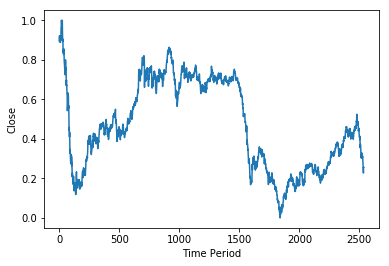

In [32]:
plt.plot(y)
plt.xlabel("Time Period")
plt.ylabel("Close")

In [39]:
# Your answer comes here.
SEQ_LEN = 5

# build a dataset
dataX = []
dataY = []

for i in range(0, len(y) - SEQ_LEN):
    _x = x[i:i + SEQ_LEN]
    _y = y[i + SEQ_LEN]
    dataX.append(_x)
    dataY.append(_y)

dataX = np.array(dataX)
dataY = np.array(dataY)

In [40]:
dataY.shape

(2532, 1)

In [41]:
train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size
Xtrain, Xtest = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
ytrain, ytest = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

In [42]:
np.shape(Xtrain), np.shape(Xtest)

((2025, 5, 15), (507, 5, 15))

In [50]:
# Your answer comes here.
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(LSTM(128, input_shape=(5, 15),return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            73728     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Your answer comes here.
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(LSTM(128, input_shape=(5, 15),return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            73728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 135,585
Trainable params: 135,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Your answer comes here.
from keras.callbacks import TensorBoard
import time
now = time.strftime("%c")
callbacks_list = [
    ModelCheckpoint(filepath='stock'+now+'.h5',monitor='val_loss',save_best_only=True)
]
history=model.fit(Xtrain, ytrain,batch_size = 128,epochs=100,validation_split = 0.2, verbose=1,callbacks=callbacks_list)

Train on 1620 samples, validate on 405 samples
Epoch 1/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.1321 - mean_absolute_error: 0.2967 - val_loss: 0.1248 - val_mean_absolute_error: 0.3517
Epoch 2/100
1620/1620 [==============================] - 0s 201us/step - loss: 0.0183 - mean_absolute_error: 0.1117 - val_loss: 0.0367 - val_mean_absolute_error: 0.1857
Epoch 3/100
1620/1620 [==============================] - 0s 209us/step - loss: 0.0092 - mean_absolute_error: 0.0757 - val_loss: 0.0437 - val_mean_absolute_error: 0.2045
Epoch 4/100
1620/1620 [==============================] - 0s 181us/step - loss: 0.0064 - mean_absolute_error: 0.0617 - val_loss: 0.0386 - val_mean_absolute_error: 0.1920
Epoch 5/100
1620/1620 [==============================] - 0s 187us/step - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0206 - val_mean_absolute_error: 0.1369
Epoch 6/100
1620/1620 [==============================] - 0s 204us/step - loss: 0.0034 - mean_absolute_error: 0

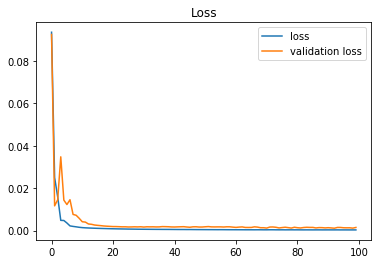

In [52]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

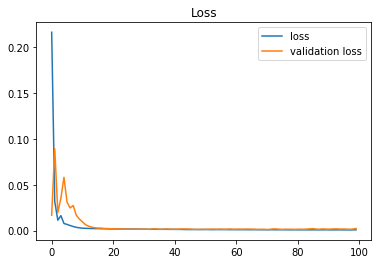

In [55]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [56]:
model = load_model('stockThu Jun 13 02:43:04 2019.h5')  # best model 불러오기
test_predict = model.predict(Xtest)
test_predict_back = scalery.inverse_transform(test_predict)
ytest_back = scalery.inverse_transform(ytest)

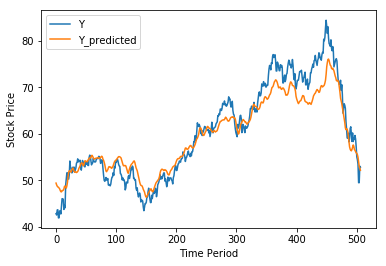

In [274]:
# Plot predictions
plt.plot(ytest_back, label = 'Y')
plt.plot(test_predict_back, label = 'Y_predicted')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

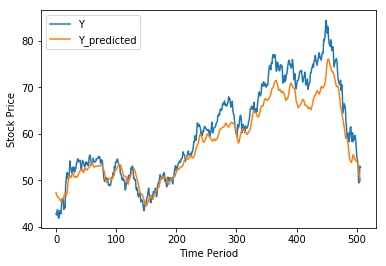

In [57]:
# Plot predictions
plt.plot(ytest_back, label = 'Y')
plt.plot(test_predict_back, label = 'Y_predicted')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [275]:
mean_absolute_error(test_predict_back, ytest_back), np.mean(test_predict_back / ytest_back) - 1

(2.5998912590072, -0.006436092888528866)

In [58]:
mean_absolute_error(test_predict_back, ytest_back), np.mean(test_predict_back / ytest_back) - 1

(2.8162882179997606, -0.03295545504027042)

In [286]:
!jupyter nbconvert --to html --TemplateExporter.exclude_input=True WTI_oil_price_predict.ipynb

[NbConvertApp] Converting notebook WTI_oil_price_predict.ipynb to html
[NbConvertApp] Writing 398513 bytes to WTI_oil_price_predict.html
